# New York University

## Applied Data Science 2016 - Final Project
-----
## Measuring Household Income in Latin America using REDATAM

#### Project description: 
Lorem ipsum

**Sources:**
- http://dlab-geo.github.io/geocoding-geopy/slides/index.html#2
- https://gist.github.com/rgdonohue/c4beedd3ca47d29aef01
- http://darribas.org/gds_scipy16/ipynb_md/07_spatial_clustering.html
- https://glenbambrick.com/2016/01/09/csv-to-shapefile-with-pyshp/

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import unicodedata

## Get data

In [2]:
data = pd.read_csv('base.csv')
data.head()

,direccion,barrio,metraje,moneda,precio,operacion,tipoPropiedad,fecha
0,Av. Díaz Vélez 4200,Almagro,88.0,dolares,172500.0,venta,departamento,2015-08-20
1,Av. Díaz Vélez 4200,Almagro,60.0,dolares,117000.0,venta,departamento,2015-08-20
2,Av. Díaz Vélez 4200,Almagro,35.0,dolares,78000.0,venta,departamento,2015-08-20
3,Av. Díaz Vélez 4200,Almagro,46.0,dolares,97600.0,venta,departamento,2015-08-20
4,Trelles 1800,Caballito,45.0,dolares,75000.0,venta,departamento,2015-08-20


In [5]:
import geopandas as gp
GBA = gp.read_file('GBA/AGBA_2010_FINAL_conpobla.shp')
GBA = GBA.loc[:,['ID_RADIO','geometry']]

In [6]:
fecha_reporte = data.fecha.max()
data = data.drop('fecha', 1)
data = data.dropna(axis=0)
data = data[data.operacion == 'venta']
data['dir_merge'] = data['direccion'] + ", " + data['barrio'] + ', Argentina'
data['$_m2'] = data.precio/data.metraje
dir_merge = data.dir_merge.unique()

In [7]:
df0 = pd.read_csv('out_addr_0.csv', sep='\t', usecols = [1,2,3])
df0.columns = ['direccion','latitude','longitude']
df1 = pd.read_csv('output_mesalve.csv', sep='\t', usecols = [1,2,3])
df1['direccion'] = df1.direccion + ', Argentina'
df2 = pd.read_csv('output.csv', sep='\t', usecols = [1,2,3])
df2['direccion'] = df2.direccion + ', Argentina'
df = pd.concat([df0,df1,df2],0)

In [8]:
addr_list0 = []
addr_list1 = []
addr_list2 = []

for i in df.direccion:
    l = unicodedata.normalize('NFKD',i.decode("utf-8")).encode('ascii','ignore')
    addr_list0.append(l)

df['direccion'] = addr_list0

for i in data.dir_merge:
    l = unicodedata.normalize('NFKD',i.decode("utf-8")).encode('ascii','ignore')
    addr_list1.append(l)

data['dir_merge'] = addr_list1

In [9]:
df_f = pd.merge(data, df, how='inner', left_on='dir_merge', right_on='direccion')
df_f = df_f.loc[:,['direccion_x','barrio','metraje','$_m2','latitude','longitude']]

for i in df_f.direccion_x:
    l = unicodedata.normalize('NFKD',i.decode("utf-8")).encode('ascii','ignore')
    addr_list2.append(l)
df_f['direccion_x'] = addr_list2
aves = df_f.groupby(['direccion_x'], axis=0)['$_m2'].mean()

In [32]:
df_f = df_f[df_f['latitude'] != 'null'].dropna()
df_f.to_csv('precios.csv')

## Spatial Clustering
-----

In [38]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale

sns.set(style="whitegrid")

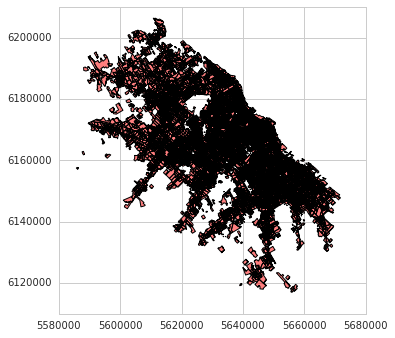

In [48]:
GBA.plot(color='red')

### Convert points (.csv) to ESRI Shapefile (.shp)
-----

In [71]:
# import libraries
import shapefile, csv

# funtion to generate a .prj file
def getWKT_PRJ (epsg_code):
    import urllib
    wkt = urllib.urlopen("http://spatialreference.org/ref/epsg/{0}/prettywkt/".format(epsg_code))
    remove_spaces = wkt.read().replace(" ","")
    output = remove_spaces.replace("\n", "")
    return output

# create a point shapefile
precios_shp = shapefile.Writer(shapefile.POINT)

# for every record there must be a corresponding geometry.
precios_shp.autoBalance = 1

# create the field names and data type for each.
precios_shp.field("DIRECCION", "C")
precios_shp.field("BARRIO", "C")
precios_shp.field("METRAJE", "C")
precios_shp.field("$_M2", "C")

# count the features
counter = 1

# access the CSV file
with open('precios.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
# skip the header
    next(reader, None)

#loop through each of the rows and assign the attributes to variables
    for row in reader:
        direccion = row[1]
        barrio = row[2]
        metraje = row[3]
        USD_m2 = row[4]
        longitude = row[5]
        latitude = row[6]

# create the point geometry
        precios_shp.point(float(longitude),float(latitude))
# add attribute data
        precios_shp.record(direccion, barrio, metraje, USD_m2)

#         print "Feature " + str(counter) + " added to Shapefile."
        counter = counter + 1

# save the Shapefile
precios_shp.save("precios_GBA")

# create a projection file
prj = open("precios_GBA.prj", "w")
epsg = getWKT_PRJ("4326")
prj.write(epsg)
prj.close()

In [65]:
GBA = GBA.to_crs({'init': 'epsg:4326'})

In [68]:
GBA.to_file(filename='temp_shp.shp',driver='ESRI Shapefile')

In [69]:
nadoti = gp.read_file('temp_shp.shp')

In [72]:
# need to install Rtree and spatial index
# Install in MacOS X, brew install spatialindex

import shapefile
import shapely

#Load the shapefile of polygons and convert it to shapely polygon objects
polygons_sf = shapefile.Reader("temp_shp.shp")
polygon_shapes = polygons_sf.shapes()
polygon_points = [q.points for q in polygon_shapes ]
from shapely.geometry import Polygon
polygons = [Polygon(q) for q in polygon_points]

#Load the shapefile of points and convert it to shapely point objects
points_sf = shapefile.Reader("precios_GBA.shp")
point_shapes = points_sf.shapes()
from shapely.geometry import Point
point_coords= [q.points[0] for q in point_shapes ]
points = [Point(q.points[0]) for q in point_shapes ]

#Build a spatial index based on the bounding boxes of the polygons
from rtree import index
idx = index.Index()
count = -1
for q in polygon_shapes:
    count +=1
    idx.insert(count, q.bbox)

#Assign one or more matching polygons to each point
matches = []
for i in range(len(points)): #Iterate through each point
    temp= None
    print "Point ", i
    #Iterate only through the bounding boxes which contain the point
    for j in idx.intersection( point_coords[i]):
        #Verify that point is within the polygon itself not just the bounding box
        if points[i].within(polygons[j]):
            print "Match found! ",j
            temp=j
            break
    matches.append(temp) #Either the first match found, or None for no matches

Point  0
Point  1
Point  2
Point  3
Point  4
Point  5
Point  6
Point  7
Point  8
Point  9
Point  10
Point  11
Point  12
Point  13
Point  14
Point  15
Point  16
Point  17
Point  18
Point  19
Point  20
Point  21
Point  22
Point  23
Point  24
Point  25
Point  26
Point  27
Point  28
Point  29
Point  30
Point  31
Point  32
Point  33
Point  34
Point  35
Point  36
Point  37
Point  38
Point  39
Point  40
Point  41
Point  42
Point  43
Point  44
Point  45
Point  46
Point  47
Point  48
Point  49
Point  50
Point  51
Point  52
Point  53
Point  54
Point  55
Point  56
Point  57
Point  58
Point  59
Point  60
Point  61
Point  62
Point  63
Point  64
Point  65
Point  66
Point  67
Point  68
Point  69
Point  70
Point  71
Point  72
Point  73
Point  74
Point  75
Point  76
Point  77
Point  78
Point  79
Point  80
Point  81
Point  82
Point  83
Point  84
Point  85
Point  86
Point  87
Point  88
Point  89
Point  90
Point  91
Point  92
Point  93
Point  94
Point  95
Point  96
Point  97
Point  98
Point  99
Point  100

In [74]:
matches

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,